In [2]:
from itertools import combinations_with_replacement
from collections import Counter
import pandas as pd
import numpy as np
from math import factorial

##############################################
# Portefeuille ou indice
##############################################

def portfolio(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1, indice = False):
    
    if indice == False:
        # Espérance des Small Cap
        E_R_sc_adjusted = smallcap_ptf(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[0]

        # Espérance des Big Cap 
        E_R_bc_total = bigcap_ptf(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[0]

        # Espérance du portefeuille
        E_R = E_R_sc_adjusted + E_R_bc_total

        # Variance du small cap
        Var_R_sc_adjusted = smallcap_ptf(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[1]

        # Variance du big cap
        Var_R_bc_total = bigcap_ptf(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[1]
        
        # Espérance des Small Cap sans ajustement
        E_R_sc_ptf_total = smallcap_ptf(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[2]

        E_WY = esperance_WY(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)

        # Covariance
        Cov_R_sc_bc = E_R_sc_ptf_total * E_WY - E_R_sc_adjusted * E_R_bc_total

        # Variance du portefeuille
        Var_R = Var_R_sc_adjusted + Var_R_bc_total + 2 * Cov_R_sc_bc
    
    else:
        # Espérance des Small Cap
        E_R_sc_adjusted = smallcap_indice(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[0]

        # Espérance des Big Cap 
        E_R_bc_total = bigcap_indice(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[0]

        # Espérance du portefeuille
        E_R = E_R_sc_adjusted + E_R_bc_total

        # Variance du small cap
        Var_R_sc_adjusted = smallcap_indice(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)[1]

        # Variance du big cap
        Var_R_bc_total = bigcap_indice(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=x)[1]

        # Variance du portefeuille
        Var_R = Var_R_sc_adjusted + Var_R_bc_total
        
    return E_R, Var_R

##############################################
# Delta
##############################################

def delta(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1, Precision = False):
    
    Esperance_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
    Variance_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[1]

    Esperance_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[0]
    Variance_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[1]

    Cov = covariance_RptfRindice(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, Precision = Precision)

    Esperance = Esperance_ptf - Esperance_indice
    Var = Variance_ptf + Variance_indice - 2 * Cov
    
    return Esperance, Var

##############################################
# Poches Portefeuille
##############################################

def bigcap_ptf(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    # Espérance des Big Cap 
    E_R_bc_correct = ph * (ppc * (w_bigcap + x) + (1 - ppc) * (w_bigcap - y)) * rh  # Correct prediction outcomes
    E_R_bc_incorrect = (1 - ph) * (ppc * (w_bigcap - y) + (1 - ppc) * (w_bigcap + x)) * rb  # Incorrect prediction outcomes
    E_R_bc = (E_R_bc_correct + E_R_bc_incorrect)
    E_R_bc_total = E_R_bc * n_bigcap
    

    # Variance des Big Cap
    Var_R_bc = (ph * (rh)**2 * (ppc * (w_bigcap + x)**2 + (1 - ppc) * (w_bigcap - y)**2) + (1 - ph) * (rb)**2 * (ppc * (w_bigcap - y)**2 + (1 - ppc) * (w_bigcap + x)**2)) - E_R_bc**2
    Var_R_bc_total = Var_R_bc * n_bigcap

    return E_R_bc_total, Var_R_bc_total

def smallcap_ptf(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    # Espérance des Small Cap
    E_R_sc_ptf_correct = ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc))) * rh
    E_R_sc_ptf_incorrect = (1 - ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc)))) * rb 
    E_R_sc_ptf_total = (E_R_sc_ptf_correct + E_R_sc_ptf_incorrect) #* 1/n_smallcap_ptf * n_smallcap_ptf
    
    # Variance des Small Cap
    #Var_X_sc_ptf = ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc))) * ((rh - E_X_sc_ptf_total) ** 2) + (1 - ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc)))) * ((rb - E_X_sc_ptf_total) ** 2)
    Var_R_sc_ptf = ((((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc))) * ((rh) ** 2) + (1 - ((ph * ppc)/(ph * ppc + (1 - ph) * (1 - ppc)))) * ((rb) ** 2)) - E_R_sc_ptf_total**2)
    Var_R_sc_ptf_N = Var_R_sc_ptf / (N_ptf - n_bigcap)

    # Espérance de l'ajustement
    E_X_ajustement = (ph * ppc + (1 - ph) * (1 - ppc)) * x - (ph * (1 - ppc) + (1 - ph) * ppc) * y
    E_W_sc = 1 - n_bigcap * (w_bigcap + E_X_ajustement)

    # Variance de l'ajustement
    Var_X_ajustement = (ph * ppc + (1 - ph) * (1 - ppc)) * (x - E_X_ajustement)**2 + (ph * (1 - ppc) + (1 - ph) * ppc) * (-y - E_X_ajustement)**2
    Var_W_sc = Var_X_ajustement * n_bigcap

    # Espérance ajustée pour les rendements "Small Cap" en prenant en compte l'ajustement de poids
    E_R_sc_ptf_adj = E_R_sc_ptf_total * E_W_sc

    # Variance ajustée pour les rendements "Small Cap" en prenant en compte l'ajustement de poids
    Var_R_sc_ptf_adj = Var_R_sc_ptf_N * E_W_sc**2 + Var_W_sc * E_R_sc_ptf_total**2 + Var_W_sc * Var_R_sc_ptf_N

    return E_R_sc_ptf_adj, Var_R_sc_ptf_adj, E_R_sc_ptf_total

def ajustement(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    # Espérance de l'ajustement
    E_x_ajustement = (ph * ppc + (1 - ph) * (1 - ppc)) * x - (ph * (1 - ppc) + (1 - ph) * ppc) * y
    E_x_total = E_x_ajustement * n_bigcap

    # Variance de l'ajustement
    Var_x_ajustement = (ph * ppc + (1 - ph) * (1 - ppc)) * (x - E_x_ajustement)**2 + (ph * (1 - ppc) + (1 - ph) * ppc) * (-y - E_x_ajustement)**2
    Var_x_ajustement_total = Var_x_ajustement * n_bigcap
    return E_x_ajustement, E_x_total, Var_x_ajustement, Var_x_ajustement_total

def esperance_W(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    
    E_Adj = ajustement(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
    return 1 - n_bigcap * (w_bigcap + E_Adj)
    
    
##############################################
# Poches Indice
##############################################

def bigcap_indice(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    # Espérance des Big Cap 
    E_R_bc_correct = ph * w_bigcap * rh  # Correct prediction outcomes
    E_R_bc_incorrect = (1 - ph) * w_bigcap * rb  # Incorrect prediction outcomes
    E_R_bc = (E_R_bc_correct + E_R_bc_incorrect)
    E_R_bc_total = E_R_bc * n_bigcap
    

    # Variance des Big Cap
    Var_R_bc = ph * w_bigcap**2 * rh**2 + (1 - ph) * w_bigcap**2 * rb**2 - E_R_bc**2
    Var_R_bc_total = Var_R_bc * n_bigcap

    return E_R_bc_total, Var_R_bc_total

def smallcap_indice(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    
    # Espérance des Small Cap de l'indice
    E_R_sc_correct_indice = ph * rh
    E_R_sc_incorrect_indice = (1 - ph) * rb
    E_R_sc_total_indice = (E_R_sc_correct_indice + E_R_sc_incorrect_indice)
    E_R_sc_total_indice_adj = E_R_sc_total_indice * (1 - n_bigcap * w_bigcap)

    # Variance des Small Cap de l'indice
    Var_R_sc_indice = (ph * (rh)**2 + (1 - ph) * (rb)**2) - E_R_sc_total_indice**2
    Var_R_sc_indice_total = Var_R_sc_indice / (N_indice - n_bigcap)
    Var_R_sc_indice_adj = Var_R_sc_indice_total * (1 - n_bigcap * w_bigcap)**2

    return E_R_sc_total_indice_adj, Var_R_sc_indice_adj

##############################################
# Espérance pour Covariances
##############################################

def calculate_permutations(combination):
    element_counts = Counter(combination).values()
    return factorial(len(combination)) // np.prod([factorial(count) for count in element_counts])


def esperance_WB(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    
    elements = {
        'rhx': [rh * w_bigcap, ph * ppc, 'x'],
        'rhy': [rh * w_bigcap, ph * (1 - ppc), 'y'],
        'rby': [rb * w_bigcap, (1 - ph) * ppc, 'y'],
        'rbx': [rb * w_bigcap, (1 - ph) * (1 - ppc), 'x'],
    }

    combinations = list(combinations_with_replacement(elements.keys(), n_bigcap))

    return sum(
        calculate_permutations(combination) * np.prod([elements[element][1] for element in combination]) *
        (sum([elements[element][0] for element in combination]) * (1 - n_bigcap * w_bigcap - 
        sum([elements[element][2] == 'x' for element in combination]) * x + 
        sum([elements[element][2] == 'y' for element in combination]) * y))
        for combination in combinations
    )

def esperance_YB(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    elements = {
        'rhx': [rh * (w_bigcap + x), rh * w_bigcap, ph * ppc, 'x'],
        'rhy': [rh * (w_bigcap - y), rh * w_bigcap, ph * (1 - ppc), 'y'],
        'rby': [rb * (w_bigcap - y), rb * w_bigcap, (1 - ph) * ppc, 'y'],
        'rbx': [rb * (w_bigcap + x), rb * w_bigcap, (1 - ph) * (1 - ppc), 'x'],
    }
    
    combinations = list(combinations_with_replacement(elements.keys(), n_bigcap))

    return sum(
        calculate_permutations(combination) * np.prod([elements[element][2] for element in combination]) *
        (sum([elements[element][0] for element in combination]) * sum([elements[element][1] for element in combination]))
        for combination in combinations
    )

def esperance_WY(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1):
    elements = {
        'rhx': [rh * (w_bigcap + x), ph * ppc, 'x'],
        'rhy': [rh * (w_bigcap - y), ph * (1 - ppc), 'y'],
        'rby': [rb * (w_bigcap - y), (1 - ph) * ppc, 'y'],
        'rbx': [rb * (w_bigcap + x), (1 - ph) * (1 - ppc), 'x'],
    }

    combinations = list(combinations_with_replacement(elements.keys(), n_bigcap))

    return sum(
        calculate_permutations(combination) * np.prod([elements[element][1] for element in combination]) *
        (sum([elements[element][0] for element in combination]) * (1 - n_bigcap * w_bigcap - 
        sum([elements[element][2] == 'x' for element in combination]) * x + 
        sum([elements[element][2] == 'y' for element in combination]) * y))
        for combination in combinations
    )

def simulate_XS(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05,y=0.1, Precision = 10000):
    n_smallcap_indice = N_indice - n_bigcap
    exposition_smallcap_indice = 1 - n_bigcap * w_bigcap
    w_smallcap_indice = exposition_smallcap_indice / n_smallcap_indice
    n_smallcap_ptf = N_ptf - n_bigcap

    results = []

    for _ in range(Precision):
        returns = np.random.choice([rh, rb], size=(n_smallcap_indice,), p=[ph, (1 - ph)])
        actions_momentum = np.where(returns == rh, 1, 0)
        probas = [ppc, (1 - ppc)]
        actions_momentum_pred = np.where(actions_momentum == 1, 
                                            np.random.choice([1, 0], size=n_smallcap_indice, p=probas), 
                                            np.random.choice([0, 1], size=n_smallcap_indice, p=probas))

        weights = np.full(n_smallcap_indice, w_smallcap_indice)
        return_smallcap_indice = np.sum(returns * weights)

        sorted_indices = np.argsort(-actions_momentum_pred)
        weights[sorted_indices[:n_smallcap_ptf]] = 1 / n_smallcap_ptf
        return_smallcap_ptf = np.sum(returns[sorted_indices[:n_smallcap_ptf]] * weights[sorted_indices[:n_smallcap_ptf]])

        XS = return_smallcap_ptf * return_smallcap_indice
        results.append(XS)

    results.append(XS)
    E_XS = np.mean(results)
    
    return E_XS

##############################################
# Covariance
##############################################

def covariance_RptfRindice(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05, y=0.1, Precision = False):
    
    if Precision == False:
        E_XW = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_S = smallcap_indice(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_X = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[2]
        E_WB = esperance_WB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
        E_Y = bigcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_YB = esperance_YB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)

        E_R_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_R_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[0]

        return E_XW*E_S + E_X*E_WB + E_Y*E_S + E_YB - E_R_ptf*E_R_indice

    else:
        E_XW = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_S = smallcap_indice(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_X = smallcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[2]
        E_WB = esperance_WB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
        E_Y = bigcap_ptf(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_YB = esperance_YB(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)
        E_XS = simulate_XS(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, Precision = Precision)
        E_W = esperance_W(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)

        E_R_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        E_R_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y, indice = True)[0]

        return E_W*E_XS + E_X*E_WB + E_Y*E_S + E_YB - E_R_ptf*E_R_indice


##############################################
# Fonction de Simulation
##############################################

def simulate_portfolio(ppc=0.6, ph=0.5, rh=1, rb=-2, N_indice=100, n_bigcap=5, w_bigcap=0.1, N_ptf=30, x=0.05,y=0.1):
    n_smallcap_indice = N_indice - n_bigcap
    exposition_smallcap_indice = 1 - n_bigcap * w_bigcap
    w_smallcap_indice = exposition_smallcap_indice/1/n_smallcap_indice
    n_smallcap_ptf = N_ptf - n_bigcap

    returns = np.random.choice([rh, rb], size=(N_indice,), p=[ph, (1 - ph)])
    actions_momentum = np.where(returns == rh, 1, 0)
    probas = [ppc, (1 - ppc)]
    actions_momentum_pred = np.where(actions_momentum == 1, 
                                     np.random.choice([1, 0], size=N_indice, p=probas), 
                                     np.random.choice([0, 1], size=N_indice, p=probas))
    actions = np.arange(N_indice)

    df_bigcap_indice = pd.DataFrame({'Actions':actions[:n_bigcap],'Returns':returns[:n_bigcap],'Momentum':actions_momentum[:n_bigcap],'Momentum_pred':actions_momentum_pred[:n_bigcap], 'Poids':w_bigcap})
    df_smallcap_indice = pd.DataFrame({'Actions':actions[n_bigcap:],'Returns':returns[n_bigcap:],'Momentum':actions_momentum[n_bigcap:],'Momentum_pred':actions_momentum_pred[n_bigcap:], 'Poids':w_smallcap_indice})
    df_indice = pd.concat([df_bigcap_indice, df_smallcap_indice])
    return_indice = np.sum(df_indice['Returns'] * df_indice['Poids'])

    df_bigcap_ptf = df_bigcap_indice.copy().assign(Poids = lambda df: df["Poids"] + df["Momentum_pred"].map({1: x, 0: -y}))
    df_smallcap_ptf = df_smallcap_indice.sort_values(by='Momentum_pred',ascending=False).head(n_smallcap_ptf).assign(Poids = (1 - df_bigcap_ptf['Poids'].sum())/1/n_smallcap_ptf)
    df_ptf = pd.concat([df_bigcap_ptf, df_smallcap_ptf])
    return_ptf = np.sum(df_ptf['Returns'] * df_ptf['Poids'])

    delta_return = return_ptf - return_indice 

    return_bigcap_ptf = np.sum(df_bigcap_ptf['Returns'] * df_bigcap_ptf['Poids'])
    return_bigcap_indice = np.sum(df_bigcap_indice['Returns'] * df_bigcap_indice['Poids'])
    return_smallcap_ptf = np.sum(df_smallcap_ptf['Returns'] * df_smallcap_ptf['Poids'])
    return_smallcap_indice = np.sum(df_smallcap_indice['Returns'] * df_smallcap_indice['Poids'])
    E_x_total = df_bigcap_ptf['Poids'].sum() - n_bigcap * w_bigcap

    W_sc = df_smallcap_ptf['Poids'].sum()
    E_WY = return_bigcap_ptf * W_sc
    
    return return_indice, return_ptf, delta_return, return_bigcap_ptf, return_smallcap_ptf,  return_bigcap_indice, return_smallcap_indice, E_x_total, W_sc, E_WY



In [107]:
#############################################
# fonction d'analyse visuelle du Portefeuille
#############################################

import matplotlib.pyplot as plt

def portfolio_analyse(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, visu = "x"):

    x=0
    y=0

    # Initialiser les listes pour stocker les résultats
    var_sc_list = []
    var_bc_list = []
    cov_list = []
    var_list = []

    # Initialiser une liste pour stocker les valeurs d'espérance
    E_sc_list = []
    E_bc_list = []
    esp_list = []

    # Définir la plage de valeurs pour y
    values = np.linspace(0, w_bigcap, 100)

    # Calculer les valeurs pour chaque x ou y de portfolio
    for value in values:
        if visu == "x":
            x = value
        elif visu == "y":
            y = value

        E_R_sc_adjusted, Var_R_sc_adjusted, E_R_sc_ptf_total = smallcap_ptf(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)
        E_R_bc_total, Var_R_bc_total = bigcap_ptf(ppc=ppc, ph=ph, rh=rh, rb=rb, N_indice=N_indice, n_bigcap=n_bigcap, w_bigcap=w_bigcap, N_ptf=N_ptf, x=x, y=y)
        E_WY = esperance_WY(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, 0, y)
        Cov_R_sc_bc = 2 * (E_R_sc_ptf_total * E_WY - E_R_sc_adjusted * E_R_bc_total)
        
        # Ajouter les valeurs d'espérance à la liste
        E_sc_list.append(E_R_sc_adjusted)
        E_bc_list.append(E_R_bc_total)
        var_sc_list.append(Var_R_sc_adjusted)
        var_bc_list.append(Var_R_bc_total)

        cov_list.append(Cov_R_sc_bc)
        var_list.append(Var_R_sc_adjusted + Var_R_bc_total + 2 * Cov_R_sc_bc)
        esp_list.append(E_R_sc_adjusted + E_R_bc_total)

    # Calculer la somme des variances et de la covariance
    sum_var_values_sc = np.array(var_sc_list) + 2 * np.array(cov_list)
    sum_var_values_total = np.array(var_bc_list) + np.array(var_sc_list) + 2 * np.array(cov_list)

    if cov_list[-1] > 0:
        # Normaliser les valeurs de variance et de covariance
        cov_list_norm = (2 * np.array(cov_list)) / var_list * 100
        var_sc_list_norm = (np.array(var_sc_list) + (2 * np.array(cov_list))) / var_list * 100
        var_bc_list_norm = (np.array(var_bc_list) + np.array(var_sc_list) + (2 * np.array(cov_list))) / var_list * 100
    else:
        # Normaliser les valeurs de variance et de covariance
        cov_list_norm = (2 * np.array(cov_list)) / var_list * 100
        var_sc_list_norm = (np.array(var_sc_list)) / var_list * 100
        var_bc_list_norm = (np.array(var_bc_list) + np.array(var_sc_list)) / var_list * 100


    # Calculer la somme des variances et de la covariance
    sum_E_values_sc = np.array(E_sc_list)
    sum_E_values_total = np.array(E_sc_list) + np.array(E_bc_list)

    # Calculer la proportion de chaque espérance par rapport à la somme totale
    E_sc_list_norm = (np.array(E_sc_list)) / esp_list * 100
    E_bc_list_norm = (np.array(E_bc_list) + np.array(E_sc_list)) / esp_list * 100

    # Initialiser une figure avec 4 sous-graphiques
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))

    # Titre de la figure
    fig.suptitle('Analyse du portefeuille en fonction de ' + visu)

    ############
    # Classique
    ############

    # Tracer l'espérance
    axs[0, 0].plot(values, E_bc_list, label='Espérance BC')
    axs[0, 0].plot(values, E_sc_list, label='Espérance SC')
    axs[0, 0].legend()
    axs[0, 0].set_xlabel(visu)
    axs[0, 0].set_ylabel('Espérance')

    # Tracer la variance et la covariance
    axs[0, 1].plot(values, var_bc_list, label='Variance BC')
    axs[0, 1].plot(values, var_sc_list, label='Variance SC')
    axs[0, 1].plot(values, cov_list, label='Covariance')
    axs[0, 1].legend()
    axs[0, 1].set_xlabel(visu)
    axs[0, 1].set_ylabel('Variance/Covariance')

    ############
    # Cumulée
    ############

    # Tracer l'espérance cumulée
    axs[1, 0].plot(values, sum_E_values_total, label='Espérance Total')
    axs[1, 0].plot(values, sum_E_values_sc, label='Espérance SC')
    # Colorer l'aire sous chaque courbe
    axs[1, 0].fill_between(values, sum_E_values_total, color='blue', alpha=0.1)
    axs[1, 0].fill_between(values, sum_E_values_sc, color='orange', alpha=0.1)
    axs[1, 0].legend()
    axs[1, 0].set_xlabel(visu)
    axs[1, 0].set_ylabel('Espérance cumulée')

    # Tracer le cumul des variances, de la covariance et de leur somme
    axs[1, 1].plot(values, sum_var_values_total, label='Variance Total')
    axs[1, 1].plot(values, sum_var_values_sc, label='Variance SC + 2 Covariance')
    axs[1, 1].plot(values, cov_list, label='Covariance')
    # Colorer l'aire sous chaque courbe
    axs[1, 1].fill_between(values, sum_var_values_total, color='blue', alpha=0.1)
    axs[1, 1].fill_between(values, sum_var_values_sc, color='orange', alpha=0.1)
    axs[1, 1].fill_between(values, cov_list, color='green', alpha=0.1)
    axs[1, 1].legend()
    axs[1, 1].set_xlabel(visu)
    axs[1, 1].set_ylabel('Variance/Covariance cumulée')

    ############
    # Proportion
    ############

    # Tracer la proportion de chaque espérance
    axs[2, 0].fill_between(values, E_bc_list_norm, color='blue', alpha=0.5, label="Proportion d'Espérance BC")
    axs[2, 0].fill_between(values, E_sc_list_norm, color='orange', alpha=0.5, label="Proportion d'Espérance SC")
    axs[2, 0].legend()
    axs[2, 0].set_xlabel(visu)
    axs[2, 0].set_ylabel("Proportion d'Espérance (%)")

    # Tracer la proportion de chaque variance
    axs[2, 1].fill_between(values, var_bc_list_norm, color='blue', alpha=0.5, label="Proportion de BigCap")
    axs[2, 1].fill_between(values, var_sc_list_norm, color='orange', alpha=0.5, label="Proportion de SmallCap")
    axs[2, 1].fill_between(values, cov_list_norm, color='green', alpha=0.5, label="Proportion de Covariance")
    axs[2, 1].legend()
    axs[2, 1].set_xlabel(visu)
    axs[2, 1].set_ylabel('Proportion de Variance/Covariance (%)')

    plt.tight_layout()
    plt.show()


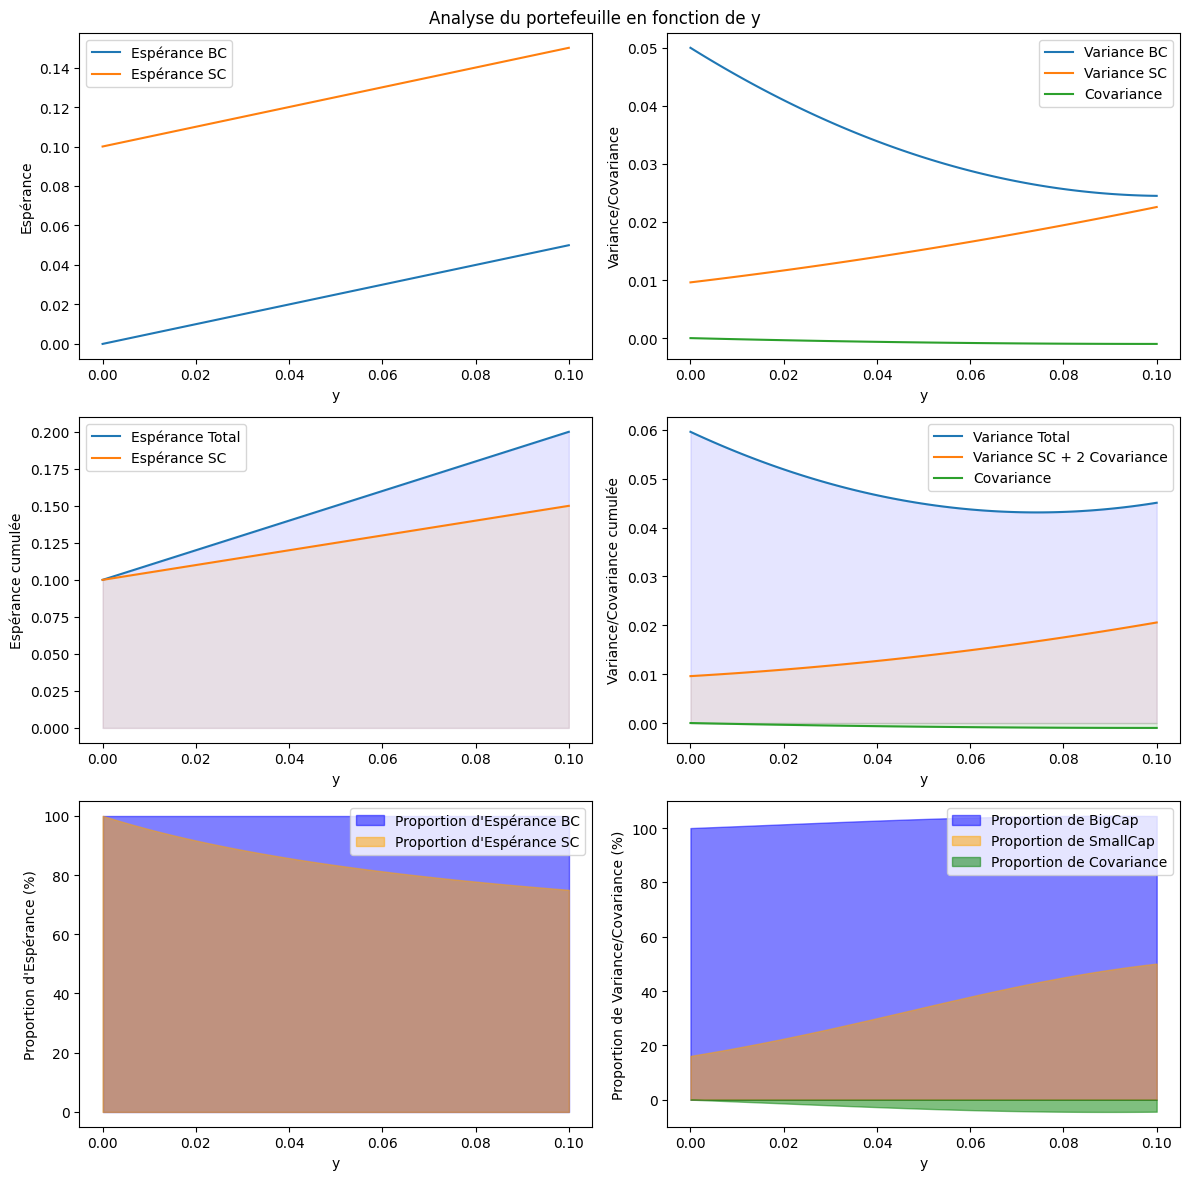

In [128]:
ppc = 0.6
ph = 0.5
rh = 1
rb = -1
N_indice = 100
n_bigcap = 5
w_bigcap = 0.1
N_ptf = 30

visu = "y"
portfolio_analyse(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, visu)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Univers :

ppc=0.6
ph=0.5
rh=1
rb=-1   
N_indice=100
n_bigcap=5
w_bigcap=0.1
N_ptf=30


# Créer des listes pour x et y
x_values = w_bigcap * np.linspace(0, 1, 100)
y_values = w_bigcap * np.linspace(0, 1, 100)

# Créer une liste pour stocker les valeurs de Sharpe
sharpe_values = []

# Calculer le ratio de Sharpe pour chaque paire (x, y)
for y in x_values:
    for x in y_values:
        Esperance = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[0]
        Variance = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x, y)[1]
        sharpe = Esperance / np.sqrt(Variance)
        sharpe_values.append(sharpe)

# Convertir les listes en arrays numpy pour la visualisation
x_values, y_values = np.meshgrid(x_values, y_values)
sharpe_values = np.array(sharpe_values).reshape(x_values.shape)

"""fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter(x_values, y_values, sharpe_values, c=sharpe_values, cmap='BrBG', linewidth=0.5)
"""

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.contour3D(x_values, y_values, sharpe_values, 100, cmap='binary')

# Find the index of the maximum Sharpe ratio
max_index = np.argmax(sharpe_values)
min_index = np.argmin(sharpe_values)

# Convert the index to 2D indices
max_indices = np.unravel_index(max_index, sharpe_values.shape)
min_indices = np.unravel_index(min_index, sharpe_values.shape)

# Find the corresponding x and y values
best_x = x_values[max_indices]
best_y = y_values[max_indices]
max_z = np.max(sharpe_values)
min_z = np.min(sharpe_values)

ax.plot([best_x, best_x], [best_y, best_y], [min_z, max_z], color='red')

# Ajouter des titres aux axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Sharpe Ratio')

ax.text(best_x, best_y, min_z, f" ({best_x:.4f}x, {best_y:.4f}y)", color='red')
ax.text(best_x, best_y, max_z + 0.05, f"{max_z:.4f} Sharpe Ratio", color='red')

# Afficher le graphique
plt.show()

print("Pour n_bigcap = ", n_bigcap, " et w_bigcap = ", w_bigcap)

print("\nBest x:", best_x)
print("Best y:", best_y)

print("\nDelta Sharpe ratio:", sharpe_values[max_indices])

sharpe_ptf = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, best_x, best_y)[0] / np.sqrt(portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, best_x, best_y)[1])
sharpe_indice = portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, best_x, best_y, indice = True)[0] / np.sqrt(portfolio(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, best_x, best_y, indice = True)[1])

print("\nPortfolio Sharpe ratio:", sharpe_ptf)
print("Indice Sharpe ratio:", sharpe_indice)

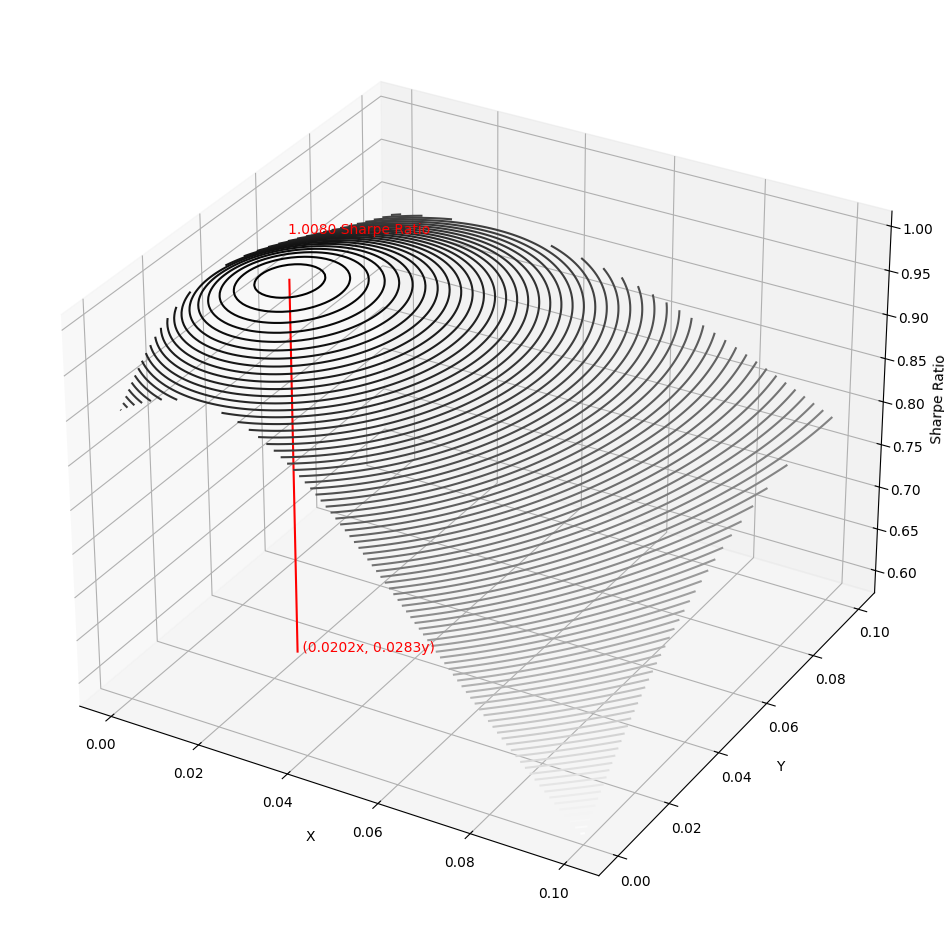

Pour n_bigcap =  5  et w_bigcap =  0.1

Best x: 0.020202020202020207
Best y: 0.028282828282828288

Delta Sharpe ratio: 1.0080367538357498


In [129]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Univers :
ppc=0.6
ph=0.5
rh=1
rb=-1   
N_indice=100
n_bigcap=5
w_bigcap=0.1
N_ptf=30

# Créer des listes pour x et y
x_values = w_bigcap * np.linspace(0, 1, 100)
y_values = w_bigcap * np.linspace(0, 1, 100)

# Créer une grille de valeurs x et y
x_values, y_values = np.meshgrid(x_values, y_values)

# Vectoriser la fonction portfolio pour l'appliquer à chaque paire de valeurs x et y
v_function = np.vectorize(delta)
Esperance, Variance = v_function(ppc, ph, rh, rb, N_indice, n_bigcap, w_bigcap, N_ptf, x_values, y_values)

# Calculer le ratio de Sharpe pour chaque paire (x, y)
sharpe_values = Esperance / np.sqrt(Variance)

# Créer un graphique 3D
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.contour3D(x_values, y_values, sharpe_values, 100, cmap='binary')

# Find the index of the maximum Sharpe ratio
max_index = np.argmax(sharpe_values)

# Convert the index to 2D indices
max_indices = np.unravel_index(max_index, sharpe_values.shape)

# Find the corresponding x and y values
best_x = x_values[max_indices]
best_y = y_values[max_indices]
max_z = np.max(sharpe_values)
min_z = np.min(sharpe_values)

ax.plot([best_x, best_x], [best_y, best_y], [min_z, max_z], color='red')

# Ajouter des titres aux axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Sharpe Ratio')

ax.text(best_x, best_y, min_z, f" ({best_x:.4f}x, {best_y:.4f}y)", color='red')
ax.text(best_x, best_y, max_z + 0.05, f"{max_z:.4f} Sharpe Ratio", color='red')

# Afficher le graphique
plt.show()

print("Pour n_bigcap = ", n_bigcap, " et w_bigcap = ", w_bigcap)
print("\nBest x:", best_x)
print("Best y:", best_y)
print("\nDelta Sharpe ratio:", sharpe_values[max_indices])

In [118]:
np.sqrt(4 + 4)

2.8284271247461903